In [14]:
# Imports
import numpy as np
from PIL import Image
from keras import backend
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b
import tensorflow as tf

In [15]:
# Hyperparams 全局变量
ITERATIONS = 10 # 迭代次数
CHANNELS = 3 # 通道数 （RGB 则为三通道）
IMAGE_SIZE = 600 # 图像大小（长/宽）
IMAGE_WIDTH = IMAGE_SIZE # 图像长
IMAGE_HEIGHT = IMAGE_SIZE # 图像宽
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939] # ImageNet 数据集 中的 RGB 平均值
CONTENT_WEIGHT = 0.02 # 内容图片权重，即输入图片
STYLE_WEIGHT = 4.5 # 画风图片权重
TOTAL_VARIATION_WEIGHT = 0.995 # 总变分 权重
TOTAL_VARIATION_LOSS_FACTOR = 1.25 # 总变分 损失因数

In [16]:
# Paths 图片路径
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"
combined_image_path = "combined.png"

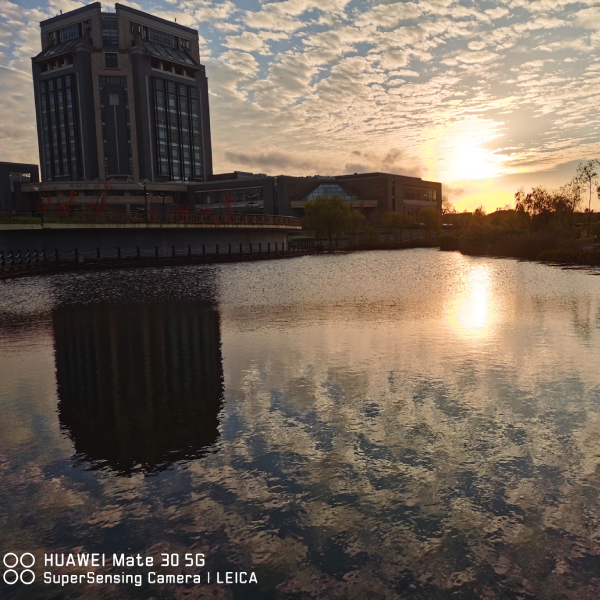

In [17]:
#Input visualization 可视化输入
input_image = Image.open(input_image_path)
input_image = input_image.convert('RGB')
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save(input_image_path)
input_image

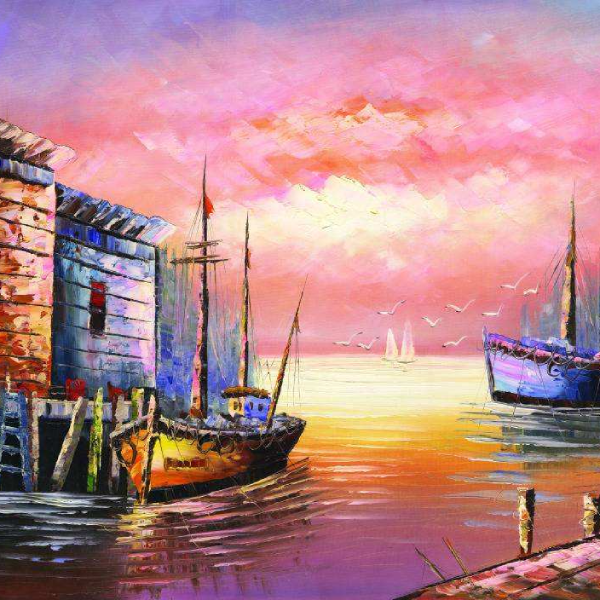

In [18]:
# Style visualization 可视化风格图像输入
style_image = Image.open(style_image_path)
style_image = style_image.convert('RGB')
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

In [19]:
# Data normalization and reshaping from RGB to BGR
# 输入图片数据标准化，并从 RGB 变形为 BGR
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]
input_image_array.shape

(1, 600, 600, 3)

In [20]:
# 风格图片数据标准化，并从 RGB 变形为 BGR
style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]
style_image_array.shape

(1, 600, 600, 3)

In [21]:
# Model
# 将图像输入 VGG16 模型

# 将图像上传到 keras 后端
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)

# 在 keras 上为合成的图像准备占位符
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

# 准备模型的输入张量
input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)

# 实例化模型
model = VGG16(input_tensor=input_tensor, include_top=False)

In [22]:
# 计算原图的损失值的函数
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content)) # 输出值与原图之差的平方和

# 存储模型中的每一层层到字典
layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2" # 指定原图所在的层的名字
layer_features = layers[content_layer] # 获取该层的输出张量 —— 该层的特征
content_image_features = layer_features[0, :, :, :] # 从中提取原图特征
combination_features = layer_features[2, :, :, :] # 从中提取最终输出结果的特征

loss = backend.variable(0.) # 声明损失值变量
loss = loss + CONTENT_WEIGHT * content_loss(content_image_features,combination_features) # 基于内容图片权重计算损失值

In [23]:
# 计算格拉姆矩阵
def gram_matrix(x):
    #对四维矩阵进行转置，并将 n 维的张量拉平为二维张量，将第 0 维相同的放在一起
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    # 求features和它自身的转置矩阵的点积
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [24]:
# 计算损失（即损失函数）
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

# 声明风格的层
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]

# 输入每一层，基于画风图片权重计算该层损失值
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

In [25]:
# 基于总变分权重计算总变分损失
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [26]:
#tf.compat.v1.disable_eager_execution()#这行设置用于解决一个和tensorflow版本有关的小bug
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

# 计算损失值和梯度值
def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

# 定义评估器类
class Evaluator:
    # 获得损失值（计算当前损失）
    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    # 获得当前的梯度
    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Starting iteration #0 
Iteration #0 completed with loss 88537489408
Starting iteration #1 
Iteration #1 completed with loss 30028593152
Starting iteration #2 
Iteration #2 completed with loss 19486406656
Starting iteration #3 
Iteration #3 completed with loss 17223737344
Starting iteration #4 
Iteration #4 completed with loss 16170373120
Starting iteration #5 
Iteration #5 completed with loss 15445362688
Starting iteration #6 
Iteration #6 completed with loss 14898768896
Starting iteration #7 
Iteration #7 completed with loss 14498880512
Starting iteration #8 
Iteration #8 completed with loss 14151589888
Starting iteration #9 
Iteration #9 completed with loss 13864413184


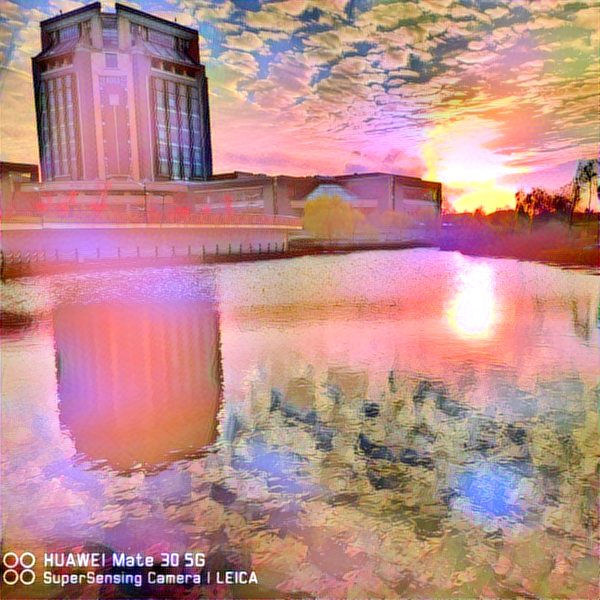

In [27]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128. # 从 [0,255) 的均匀分布中随机生成，
                                                                        # 大小为 (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3) 的矩阵
                                                                        # 减去128（即每个元素控制在 [-128, 127)）
                                                                        # 这个即为迭代初始值，从这里开始计算梯度

# 执行迭代
for i in range(ITERATIONS):
    print("Starting iteration #%d " % i)
    x, loss, info = fmin_l_bfgs_b( # 使用 L-BFGS-B 算法求函数最小值
        evaluator.loss, # 待求函数 —— 求损失函数最小值
        x.flatten(), # 初始值（从这个值开始猜测），将上述随机生成的矩阵平铺后输入
        fprime=evaluator.gradients, # 梯度函数 —— 直接输入梯度函数
        maxfun=20) # 最大尝试执行函数的次数
    print("Iteration #%d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)) # 将 x 矩阵变形为 (图像长度，图像宽度，通道数) 的矩阵
x = x[:, :, ::-1] # 将最后一维度倒序（即三个通道倒序）
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2] # 将 ImageNet 数据集中的平均值加到矩阵上
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8") # 将每个数值限制在 0-255，并转换成 uint8（8位无符号整型）
output_image = Image.fromarray(x) # 将 x 矩阵作为输出图像
output_image.save(output_image_path) # 保存图像
#输出结果
output_image

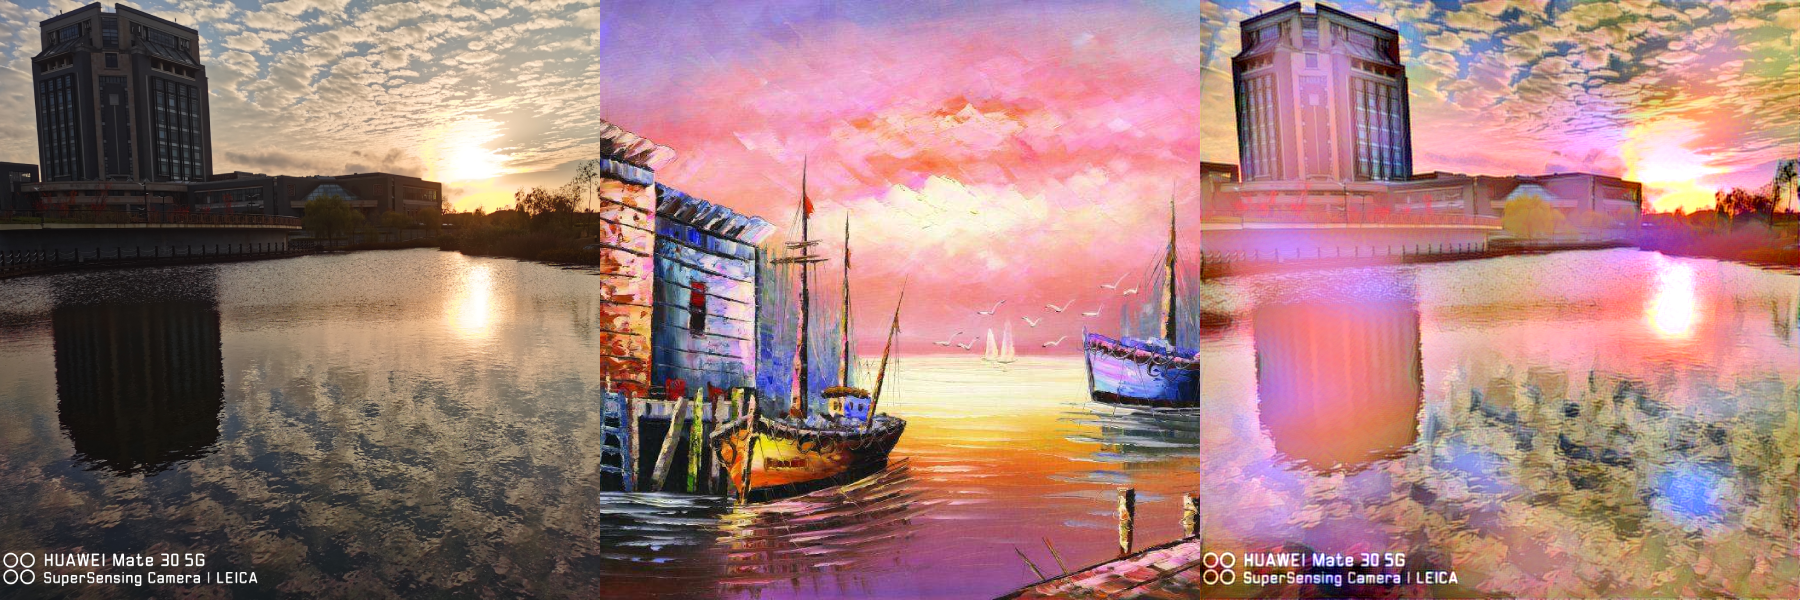

In [28]:
# Visualizing combined results 将输入图片，风格图片，输出图片拼接起来，可视化整个结果
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined